# Imports

In [1]:
from pathlib import Path
from functools import partial
from collections import defaultdict
import math
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vision_utils
import lpips
from torchinfo import summary
from torchvision.datasets import LSUN
from torch.utils.data import DataLoader, random_split
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0

In [3]:
device

device(type='cuda')

https://github.com/samb-t/unleashing-transformers/blob/master/models/vqgan.py
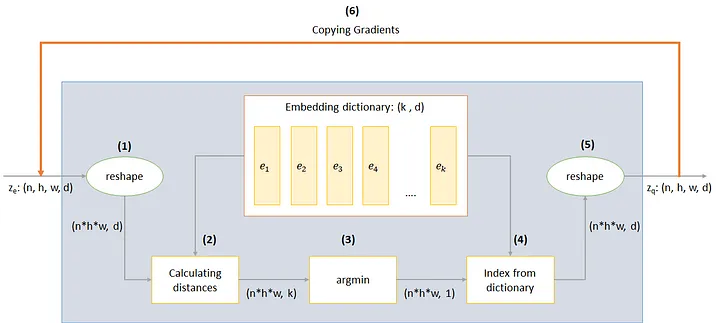

# Datasets

## Random Minecraft Chunks

In [4]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# import numpy as np

# class MinecraftDataset(Dataset):
#     def __init__(self, data_path):
#         # Load data
#         chunks = torch.from_numpy(np.load(data_path))
        
#         # Create block type mappings
#         unique_blocks = torch.unique(chunks).numpy()
#         self.num_block_types = len(unique_blocks)
        
#         # Create mappings
#         self.block_to_index = {int(block): idx for idx, block in enumerate(unique_blocks)}
#         self.index_to_block = {idx: int(block) for idx, block in enumerate(unique_blocks)}
        
#         # Convert entire dataset at once to new indices
#         self.chunks = torch.tensor([[[[self.block_to_index[int(b)] 
#                                      for b in row] 
#                                     for row in layer]
#                                    for layer in slice_]
#                                   for slice_ in chunks])
        
#         # Store air block index
#         self.air_idx = self.block_to_index[5]
#         self.target_size = 24

#         # Pre-process all chunks (pad and one-hot encode)
#         pad_size = self.target_size - self.chunks.size(-1)
#         padded_chunks = F.pad(self.chunks, 
#                             (0, pad_size, 0, pad_size, 0, pad_size), 
#                             value=self.air_idx)
#         # Convert to one-hot [N, C, H, W, D]
#         self.processed_chunks = F.one_hot(
#             padded_chunks.long(), 
#             num_classes=self.num_block_types
#         ).permute(0, 4, 1, 2, 3).float()
        
#         print(f"Loaded {len(self.chunks)} chunks of size {self.chunks.shape[1:]}")
#         print(f"Number of unique block types: {self.num_block_types}")
#         print(f'unique blocks original: {np.unique(chunks.numpy())}')
#         print(f'unique blocks after: {np.unique(self.chunks.numpy())}')
#         print(f"Block mapping: {self.block_to_index}")
#         print(f"Air block is now index: {self.air_idx}")

#     def __getitem__(self, idx):
#         return self.processed_chunks[idx]

#     def convert_to_original_blocks(self, data):
#         """Convert from indices back to original block IDs"""
#         if len(data.shape) == 5:  # [B, C, H, W, D] or [C, H, W, D]
#             data = torch.argmax(data, dim=1 if len(data.shape) == 5 else 0)
#         return torch.tensor([[[[self.index_to_block[int(b)] 
#                               for b in row]
#                              for row in layer]
#                             for layer in slice_]
#                            for slice_ in data])

#     def __len__(self):
#         return len(self.chunks)

# def get_minecraft_dataloaders(data_path, batch_size=32, val_split=0.1, num_workers=4):
#     """
#     Creates training and validation dataloaders for Minecraft chunks.
#     """
#     # Create dataset
#     dataset = MinecraftDataset(data_path)
    
#     # Split into train and validation sets
#     val_size = int(val_split * len(dataset))
#     train_size = len(dataset) - val_size
    
#     # Use a fixed seed for reproducibility
#     generator = torch.Generator().manual_seed(42)
    
#     train_dataset, val_dataset = torch.utils.data.random_split(
#         dataset, 
#         [train_size, val_size],
#         generator=generator
#     )
    
#     # Create dataloaders with memory pinning
#     train_loader = DataLoader(
#         train_dataset,
#         batch_size=batch_size,
#         shuffle=True,
#         num_workers=num_workers,
#         pin_memory=True,
#     )
    
#     val_loader = DataLoader(
#         val_dataset,
#         batch_size=batch_size,
#         shuffle=False,
#         num_workers=num_workers,
#         pin_memory=True,
#     )

#     # Store conversion function in the loaders
#     train_loader.convert_to_original_blocks = dataset.convert_to_original_blocks
#     val_loader.convert_to_original_blocks = dataset.convert_to_original_blocks
    
#     print(f"\nDataloader details:")
#     print(f"Training samples: {len(train_dataset)}")
#     print(f"Validation samples: {len(val_dataset)}")
#     print(f"Batch size: {batch_size}")
#     print(f"Training batches: {len(train_loader)}")
#     print(f"Validation batches: {len(val_loader)}")
    
#     return train_loader, val_loader


### Render Minecraft data

In [5]:
class MinecraftVisualizer:
    def __init__(self):
        """Initialize the visualizer with the same block color mappings"""
        self.blocks_to_cols = {
            0: (0.5, 0.25, 0.0),    # light brown
            29: "#006400",
            38: "#B8860B",
            60: "brown",
            92: "gold",
            93: "green",
            115: "brown",
            119: "forestgreen",
            120: "forestgreen",
            194: "yellow",
            217: "gray",
            227: "#90EE90",
            240: "blue",
            40: "#2F4F4F",
            62: "#228B22",
            108: "#BEBEBE",
            131: "saddlebrown",
            132: "saddlebrown",
            95: "lightgray",
            243: "wheat",
            197: "limegreen",
            166: "orange",
            167: "#FF8C00",
            184: "#FFA07A",
            195: "tan",
            250: "white",
            251: "gold",
        }

    def visualize_chunk(self, voxels, ax=None):
        """
        Create a 3D visualization of a Minecraft chunk using the original plotting logic.
        
        Args:
            voxels: torch.Tensor [C,H,W,D] (one-hot) or numpy.ndarray [H,W,D] (block IDs)
            ax: Optional matplotlib axis
        """
        # Convert one-hot to block IDs if needed
        if isinstance(voxels, torch.Tensor):
            if voxels.dim() == 4:  # One-hot encoded [C,H,W,D]
                voxels = voxels.detach().cpu()
                voxels = torch.argmax(voxels, dim=0).numpy()
            else:
                voxels = voxels.detach().cpu().numpy()

        # Apply the same transformations as original
        voxels = voxels.transpose(2, 0, 1)
        # Rotate the voxels 90 degrees around the height axis
        voxels = np.rot90(voxels, 1, (0, 1))

        # Create axis if not provided
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

        # Plot non-air blocks
        other_vox = (voxels != 5) & (voxels != -1)
        
        # Plot each block type with its color
        for block_id in np.unique(voxels[other_vox]):
            if block_id not in self.blocks_to_cols:
                # print(f"Unknown block id: {block_id}")
                continue
            ax.voxels(voxels == block_id, facecolors=self.blocks_to_cols[int(block_id)])
            other_vox = other_vox & (voxels != block_id)

        # Plot remaining blocks in red with black edges
        ax.voxels(other_vox, edgecolor="k", facecolor="red")
        
        return ax

In [6]:
def display_minecraft(vis, mc_visualizer, data, mc_dataset, win_name="minecraft_display", title="Minecraft Chunks", nrow=4, save_path=None):
    """
    Display or save multiple minecraft chunks.
    
    Args:
        vis: Visdom instance (can be None if only saving)
        data: Tensor of shape [B, 256, 20, 20, 20] or [B, 20, 20, 20]
        win_name: Window name for visdom
        title: Title for the plot
        nrow: Number of images per row
        save_path: If provided, saves the figure to this path
    """
    # Convert to original block IDs for visualization
    data = mc_dataset.convert_to_original_blocks(data)
    # Convert to one-hot if needed
    if len(data.shape) == 4:  # [B, 20, 20, 20]
        data = F.one_hot(data.long(), num_classes=256).permute(0, 4, 1, 2, 3).float()
    
    # Create figure with subplots
    batch_size = min(data.shape[0], 16)  # Display up to 16 chunks
    ncols = nrow
    nrows = (batch_size + ncols - 1) // ncols
    
    fig = plt.figure(figsize=(4*ncols, 4*nrows))
    fig.suptitle(title)
    
    for i in range(batch_size):
        ax = fig.add_subplot(nrows, ncols, i+1, projection='3d')
        mc_visualizer.visualize_chunk(data[i], ax)
        ax.set_title(f'Chunk {i}')
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
    
    # Display in visdom if instance provided
    if vis is not None:
        # Convert matplotlib figure to numpy array for visdom
        canvas = fig.canvas
        canvas.draw()
        width, height = canvas.get_width_height()
        img_array = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
        img_array = img_array.reshape(height, width, 3)
        
        vis.image(
            img_array.transpose(2, 0, 1),  # Convert to CHW format
            win=win_name,
            opts=dict(
                title=title,
                caption=f'Batch of {batch_size} chunks'
            )
        )
    
    plt.close(fig)

def save_minecraft(data, mc_visualizer, mc_dataset, save_path, nrow=4, title="Minecraft Chunks"):
    """
    Save multiple minecraft chunks to a file.
    
    Args:
        data: Tensor of shape [B, 256, 20, 20, 20] or [B, 20, 20, 20]
        save_path: Path to save the image
        nrow: Number of images per row
        title: Title for the plot
    """
    # Convert to original block IDs for visualization
    data = mc_dataset.convert_to_original_blocks(data)
    # Convert to one-hot if needed
    if len(data.shape) == 4:  # [B, 20, 20, 20]
        data = F.one_hot(data.long(), num_classes=256).permute(0, 4, 1, 2, 3).float()
    
    # Create figure with subplots
    batch_size = min(data.shape[0], 16)  # Save up to 16 chunks
    ncols = nrow
    nrows = (batch_size + ncols - 1) // ncols
    
    fig = plt.figure(figsize=(4*ncols, 4*nrows))
    fig.suptitle(title)
    
    for i in range(batch_size):
        ax = fig.add_subplot(nrows, ncols, i+1, projection='3d')
        mc_visualizer.visualize_chunk(data[i], ax)
        ax.set_title(f'Chunk {i}')
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close(fig)

In [7]:
# chunk_size = np.prod([256, 20, 20, 20])  # Total elements in one-hot tensor
# bytes_per_element = 4  # float32
# memory_per_chunk = chunk_size * bytes_per_element
# memory_mb = memory_per_chunk / (1024 * 1024)

# print(f"Memory per chunk (one-hot): {memory_mb:.2f} MB")
# print(f"Memory for 4 workers with batch_size=2: {memory_mb * 2 * 4:.2f} MB")

In [8]:
# train_loader, val_loader = get_minecraft_dataloaders(
#         '../datasets/minecraft_chunks.npy',
#         batch_size=2, num_workers=0   )
    
# # Get a batch
# batch = next(iter(train_loader))
# print(f"\nBatch properties:")
# print(f"Shape: {batch.shape}")
# print(f"Memory usage: {batch.element_size() * batch.nelement() / 1024 / 1024:.2f} MB")

# # Visualize first chunk
# vis = MinecraftVisualizer()
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
# vis.visualize_chunk(batch[1], ax)
# plt.show()

In [9]:
# vis = visdom.Visdom()
# # Visualize first chunk
# mc_visualizer = MinecraftVisualizer()
# # Get some test data
# train_loader, _ = get_minecraft_dataloaders(
#     '../datasets/minecraft_chunks.npy',
#     batch_size=4,
#     num_workers=0
# )

# batch = next(iter(train_loader))

# # Test display function
# display_minecraft(vis, mc_visualizer, batch, train_loader, title="Original Chunks", save_path="minecraft_vis/test_batch.png")

# Test save function
# save_minecraft(batch, mc_visualizer, "minecraft_vis/test_batch.png", title="Saved Chunks")

In [10]:
# def plot_onehot_vox_to_ax(ax, voxels: np.ndarray):
#     voxels = np.argmax(voxels, axis=0)
#     return plot_vox_to_ax(ax, voxels)

# def plot_vox_to_ax(ax, voxels: np.ndarray):
#     voxels = voxels.transpose(2, 0, 1)
#     # Rotate the voxels 90 degrees around the height axis
#     voxels = np.rot90(voxels, 1, (0, 1))
#     # Dirt blocks are brown
#     blocks_to_cols = {
#         # light brown
#         0: (0.5, 0.25, 0.0),
#         29: "#006400",
#         38: "#B8860B",
#         60: "brown",
#         92: "gold",
#         93: "green",
#         115: "brown",
#         119: "forestgreen",
#         120: "forestgreen",
#         194: "yellow",
#         217: "gray",
#         227: "#90EE90",
#         240: "blue",
#         40: "#2F4F4F",
#         62: "#228B22",
#         108: "#BEBEBE",
#         131: "saddlebrown",
#         132: "saddlebrown",
#         95: "lightgray",
#         243: "wheat",
#         197: "limegreen",
#         166: "orange",
#         167: "#FF8C00",
#         184: "#FFA07A",
#         195: "tan",
#         250: "white",
#         251: "gold",
#     }
#     # vox_air = voxels == AIR
#     # Transparent air blocks
#     # ax.voxels(voxels == AIR, facecolors="white", edgecolors="k", linewidth=0.1, alpha=0.1)
#     other_vox = (voxels != 5) & (voxels != -1)
#     for block_id in np.unique(voxels[other_vox]):
#         if block_id not in blocks_to_cols:
#             print("Unknown block id: {}".format(block_id))
#             continue
#         ax.voxels(voxels == block_id, facecolors=blocks_to_cols[int(block_id)])
#         other_vox = other_vox & (voxels != block_id)
#     ax.voxels(other_vox, edgecolor="k", facecolor="red")
#     return ax

# def plot_voxels(voxels: np.ndarray, trg_voxels: np.ndarray, save_path: str = None):
#     if trg_voxels is None:
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')
#         ax = plot_onehot_vox_to_ax(ax, voxels)
#     else:
#         fig = plt.figure()
#         ax = fig.add_subplot(121, projection='3d')
#         ax = plot_onehot_vox_to_ax(ax, voxels)
#         ax = fig.add_subplot(122, projection='3d')
#         ax = plot_onehot_vox_to_ax(ax, trg_voxels)
#         # plt.show()
#         # plt.close()
#     # Save the figure
#     return fig

### Learn to compress the data

In [11]:
# from tqdm import tqdm
# class Model(nn.Module):
#     def __init__(self, in_chan, n_hid):
#         super(Model, self).__init__()
#         self.fc1 = nn.Linear(in_chan, n_hid)
#         self.fc2 = nn.Linear(n_hid, n_hid)
#         self.fc3 = nn.Linear(n_hid, in_chan)
#         self.relu = nn.ReLU()
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.fc3(x)
#         x = self.softmax(x)
#         return x

# # Training setup
# log_dir = 'logs_compress_blocks'
# os.makedirs(log_dir, exist_ok=True)

# exp_name = "0"
# n_blocks = 256  # Changed to 256 to match your data
# n_latents = 20
# n_epochs = 100000
# log_interval = 1000

# # Initialize model and optimizer
# model = Model(n_blocks, n_latents)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # Lists to track losses for plotting
# losses = []
# discrete_losses = []

# # Training loop
# pbar = tqdm(range(n_epochs), desc="Training block embeddings")
# for i in pbar:
#     onehots = torch.eye(n_blocks)
    
#     optimizer.zero_grad()
#     out = model(onehots)
#     loss = F.mse_loss(out, onehots)
#     loss.backward()
#     optimizer.step()
    
#     # Track losses
#     losses.append(loss.item())
    
#     if i % log_interval == 0:
#         disc_out = torch.eye(n_blocks)[torch.argmax(out, dim=1)]
#         discrete_loss = F.mse_loss(disc_out, onehots)
#         discrete_losses.append(discrete_loss.item())
        
#         # Update progress bar
#         pbar.set_postfix({
#             'loss': f'{loss.item():.2e}',
#             'discrete_loss': f'{discrete_loss.item():.2e}'
#         })
        
#         # Save the model
#         torch.save({
#             'epoch': i,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss.item(),
#         }, os.path.join(log_dir, 'model_latest.pt'))
        
#         # If this is the best model so far, save it separately
#         if len(discrete_losses) == 1 or discrete_loss.item() < min(discrete_losses[:-1]):
#             torch.save({
#                 'epoch': i,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': loss.item(),
#             }, os.path.join(log_dir, 'model_best.pt'))

# # Plot training curves
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(losses)
# plt.title('Training Loss')
# plt.xlabel('Iteration')
# plt.ylabel('MSE Loss')
# plt.yscale('log')

# plt.subplot(1, 2, 2)
# plt.plot(range(0, n_epochs, log_interval), discrete_losses)
# plt.title('Discrete Loss')
# plt.xlabel('Iteration')
# plt.ylabel('Discrete MSE Loss')
# plt.yscale('log')

# plt.tight_layout()
# plt.savefig(os.path.join(log_dir, 'training_curves.png'))
# plt.show()

# # Load the best model and get embeddings
# checkpoint = torch.load(os.path.join(log_dir, 'model_best.pt'))
# model.load_state_dict(checkpoint['model_state_dict'])

# # Get the learned embeddings (from first layer weights)
# block_embeddings = model.fc1.weight.data.T

# print(f"Shape of learned embeddings: {block_embeddings.shape}")
# print(f"Final discrete loss: {discrete_losses[-1]:.2e}")

In [12]:
# import torch
# from pathlib import Path
# from tqdm import tqdm

# def encode_chunk(chunk, model):
#     # Convert chunk to one-hot
#     chunk_tensor = torch.Tensor(chunk).long()
#     chunk_onehot = torch.eye(256)[chunk_tensor]
    
#     # Get the compressed representation (output of first hidden layer)
#     with torch.no_grad():
#         x = model.fc1(chunk_onehot)
#         x = model.relu(x)
#         x = model.fc2(x)
#         x = model.relu(x)
    
#     return x

# def decode_chunk(compressed_chunk, model):
#     with torch.no_grad():
#         # Pass through final layer and softmax
#         x = model.fc3(compressed_chunk)
#         x = model.softmax(x)
#         # Convert to block IDs
#         block_ids = torch.argmax(x, dim=-1)
    
#     return block_ids


# def save_compressed_dataset(model, compressed_chunks, original_shapes, save_dir='../datasets'):
#     save_dir = Path(save_dir)
#     os.makedirs(save_dir, exist_ok=True)
    
#     # Save compressed data
#     compressed_data = {
#         'chunks': compressed_chunks,
#         'original_shapes': original_shapes,
#         'model_config': {
#             'n_blocks': 256,
#             'n_latents': model.fc1.out_features,  # Save architecture details
#         }
#     }
#     torch.save(compressed_data, save_dir / 'compressed_chunks.pt')
    
#     # Save model state
#     torch.save({
#         'model_state_dict': model.state_dict(),
#         'model_config': {
#             'n_blocks': 256,
#             'n_latents': model.fc1.out_features,
#         }
#     }, save_dir / 'compression_model.pt')

# def load_compressed_dataset(load_dir='../datasets'):
#     load_dir = Path(load_dir)
    
#     # Load compressed data
#     compressed_data = torch.load(load_dir / 'compressed_chunks.pt')
    
#     # Load model
#     model_data = torch.load(load_dir / 'compression_model.pt')
#     model = Model(
#         in_chan=model_data['model_config']['n_blocks'],
#         n_hid=model_data['model_config']['n_latents']
#     )
#     model.load_state_dict(model_data['model_state_dict'])
#     model.eval()
    
#     return compressed_data, model


# # Load all chunks and compress them
# chunks_path = Path('../datasets/samdata')
# compressed_chunks = []
# original_chunks = []

# # Load the trained model
# model.eval()  # Set to evaluation mode

# print("Compressing chunks...")
# for chunk_path in tqdm(list(chunks_path.glob('*.npy'))):
#     # Load chunk
#     chunk = np.load(chunk_path, allow_pickle=True)
#     original_chunks.append(chunk)
    
#     # Compress chunk
#     compressed = encode_chunk(chunk, model)
#     compressed_chunks.append(compressed)

# # Save compressed dataset
# compressed_data = {
#     'chunks': compressed_chunks,
#     'original_shapes': [chunk.shape for chunk in original_chunks]
# }
# torch.save(compressed_data, '../datasets/compressed_mc_chunks/compressed_chunks.pt')

# # # Print compression stats
# # original_size = sum(chunk.nbytes for chunk in original_chunks)
# # compressed_size = sum(chunk.nbytes for chunk in compressed_chunks)
# # print(f"\nCompression Statistics:")
# # print(f"Original dataset size: {original_size/1e6:.2f} MB")
# # print(f"Compressed dataset size: {compressed_size/1e6:.2f} MB")
# # print(f"Compression ratio: {original_size/compressed_size:.2f}x")

# # voxels = torch.Tensor(chunk).long()
# # voxels = torch.eye(256)[voxels]
# # voxels = voxels.permute(3, 0, 1, 2)  
# # plot_voxels(voxels.numpy(), trg_voxels=None)
# # # Also visualize using the 3D renderer
# # fig = plot_voxels(
# #     torch.eye(256)[torch.Tensor(test_chunk).long()].permute(3, 0, 1, 2),
# #     torch.eye(256)[reconstructed].permute(3, 0, 1, 2)
# # )
# # plt.show()

In [13]:

# # Test reconstruction of a random chunk
# idx = np.random.randint(len(compressed_chunks))
# test_chunk = original_chunks[idx]
# test_compressed = compressed_chunks[idx]

# # Reconstruct
# reconstructed = decode_chunk(test_compressed, model)

# print(f'test_chunk shape: {test_chunk.shape}')
# print(f'test_compressed shape: {test_compressed.shape}')
# print(f'reconstructed shape: {reconstructed.shape}')


In [14]:
# # Print compression stats
# original_size = sum(chunk.nbytes for chunk in original_chunks)
# compressed_size = sum(chunk.nbytes for chunk in compressed_chunks)
# print(f"\nCompression Statistics:")
# print(f"Original dataset size: {original_size/1e6:.2f} MB")
# print(f"Compressed dataset size: {compressed_size/1e6:.2f} MB")
# print(f"Compression ratio: {original_size/compressed_size:.2f}x")

# voxels = torch.Tensor(chunk).long()
# voxels = torch.eye(256)[voxels]
# voxels = voxels.permute(3, 0, 1, 2)  
# plot_voxels(voxels.numpy(), trg_voxels=None)
# # Also visualize using the 3D renderer
# fig = plot_voxels(
#     torch.eye(256)[torch.Tensor(test_chunk).long()].permute(3, 0, 1, 2).numpy(),
#     torch.eye(256)[reconstructed].permute(3, 0, 1, 2).numpy()
# )
# plt.show()

In [15]:
# import torch
# import numpy as np
# from pathlib import Path
# from tqdm import tqdm

# # Load all chunks and convert to one-hot
# chunks_path = Path('../datasets/samdata')
# one_hot_chunks = []

# print("Converting chunks to one-hot encoding...")
# for chunk_path in tqdm(list(chunks_path.glob('*.npy'))):
#     # Load chunk
#     chunk = np.load(chunk_path, allow_pickle=True)
    
#     # Convert to one-hot using PyTorch
#     chunk_tensor = torch.Tensor(chunk).long()
#     chunk_onehot = torch.eye(256)[chunk_tensor]
#     chunk_onehot = chunk_onehot.permute(3, 0, 1, 2)  # [C, H, W, D]
    
#     one_hot_chunks.append(chunk_onehot)

# # Stack all chunks into a single tensor
# all_chunks = torch.stack(one_hot_chunks)

# # Save the dataset
# save_path = '../datasets/minecraft_onehot.pt'
# torch.save(all_chunks, save_path)

# # Print information about the dataset
# print(f"\nDataset Statistics:")
# print(f"Number of chunks: {len(one_hot_chunks)}")
# print(f"Chunk shape: {one_hot_chunks[0].shape}")
# print(f"Total dataset shape: {all_chunks.shape}")
# print(f"Dataset size on disk: {Path(save_path).stat().st_size / (1024*1024):.2f} MB")
# print(f"Memory usage: {all_chunks.element_size() * all_chunks.nelement() / (1024*1024):.2f} MB")

# # Verify loading
# loaded_chunks = torch.load(save_path)
# print(f"\nVerified loading. Shape matches: {loaded_chunks.shape == all_chunks.shape}")

# Combine output of the data scrape script

In [16]:
# import torch
# import numpy as np
# from pathlib import Path
# from tqdm import tqdm

# # Load all chunks into a single array
# chunks_path = Path('../../text2env/data/Voxels/voxels/')
# all_chunks = []

# print("Loading and combining chunks...")
# for chunk_path in tqdm(list(chunks_path.glob('*.npy'))):
#     # Load chunk
#     chunk = np.load(chunk_path, allow_pickle=True)
#     all_chunks.append(chunk)

# # Stack into single array
# all_chunks = np.stack(all_chunks)

# # Save the combined dataset
# save_path = '../../text2env/data/voxels_combined_2.npy'
# np.save(save_path, all_chunks)

# # Print information about the dataset
# print(f"\nDataset Statistics:")
# print(f"Number of chunks: {len(all_chunks)}")
# print(f"Chunk shape: {all_chunks[0].shape}")
# print(f"Total dataset shape: {all_chunks.shape}")
# print(f"Dataset size on disk: {Path(save_path).stat().st_size / (1024*1024):.2f} MB")
# print(f"Memory usage: {all_chunks.nbytes / (1024*1024):.2f} MB")

# # Verify loading
# loaded_chunks = np.load(save_path)
# print(f"\nVerified loading. Shape matches: {loaded_chunks.shape == all_chunks.shape}")

# Model

## Vector Quantizer

In [17]:
#  Define VQVAE classes
class VectorQuantizer(nn.Module):
    def __init__(self, codebook_size, emb_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.codebook_size = codebook_size  # number of embeddings
        self.emb_dim = emb_dim  # dimension of embedding
        self.beta = beta  # commitment cost used in loss term, beta * ||z_e(x)-sg[e]||^2
        self.embedding = nn.Embedding(self.codebook_size, self.emb_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.codebook_size, 1.0 / self.codebook_size)
        # Add tracking for usage
        self.register_buffer('usage_count', torch.zeros(self.codebook_size))
        self.register_buffer('last_reset', torch.zeros(self.codebook_size))
        self.reset_threshold = 1  # Number of epochs before resetting unused vectors

    def reset_unused_codes(self, epoch):
        """Reset any embeddings that weren't used in the last epoch"""
        unused_indices = torch.where(self.usage_count == 0)[0]
    
        if len(unused_indices) > 0:
            # Reinitialize unused embeddings
            self.embedding.weight.data[unused_indices].uniform_(
            -1.0 / self.codebook_size, 
            1.0 / self.codebook_size
            )
            
            # Reset usage count for next epoch
            self.usage_count.zero_()  # Reset all counts for next epoch
            
            return len(unused_indices)
        return 0

    def forward(self, z):
        # z shape: (batch, channel, height, width, depth)
        # Reshape z -> (batch, height, width, depth, channel) and flatten
        z = z.permute(0, 2, 3, 4, 1).contiguous()
        z_flattened = z.view(-1, self.emb_dim)

        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z
        #   this gives a (batch_size * height * width, codebook_size) tensor, where each element coresponds to ther squared euclidian distance b/t i-th input and jth embedding
        d = (z_flattened ** 2).sum(dim=1, keepdim=True) + (self.embedding.weight**2).sum(1) - \
            2 * torch.matmul(z_flattened, self.embedding.weight.t())

        mean_distance = torch.mean(d)   # is this an output metric? mean distance between z and embeddings

        # find closest encodings
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)  #   gets the index of the closest embedding for each input data point (shape is (batch_size * height * width, 1))
        min_encodings = torch.zeros(min_encoding_indices.shape[0], self.codebook_size).to(z)    #   creates a tensor of zeros with shape (batch_size * height * width, codebook_size), puts it on the same device as z
        min_encodings.scatter_(1, min_encoding_indices, 1)  #   sets the value at the index of the closest embedding to 1 (one-hot encoding)

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape)  #   multiply the one-hot encodings by the embeddings to get the quantized latent vectors
        # compute loss for embedding
        loss = torch.mean((z_q.detach()-z)**2) + self.beta * torch.mean((z_q - z.detach()) ** 2)    #   two loss terms. First is the reconstruction loss b/t quantized latent vectors and input data. second is the commitment loss
        # preserve gradients
        #   This is the straight-through estimator. It allows the gradients to flow through the quantized latent vectors during backpropagation
        #   Detach the diff between quantized and original z, then add it to z. This is the same as zq, but has gradients only w.r.t z. Allows gradients to pass through as if z_q was z
        z_q = z + (z_q - z).detach()

        # perplexity
        e_mean = torch.mean(min_encodings, dim=0)   #   mean of the one-hot encodings acriss dim 0 - so every item will be how frequently that encoding happens across all samples in the batch
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))  #   perplexity measures how spread out the encoding usage is. Higher perplexity is more uniform distribution (more uncertainty), which I think is good?
        # reshape back to match original input shape
        z_q = z_q.permute(0, 4, 1, 2, 3).contiguous()

         # Update usage counts
        unique_indices = torch.unique(min_encoding_indices)
        self.usage_count[unique_indices] += 1
        
        return z_q, loss, {
            "perplexity": perplexity,
            "min_encodings": min_encodings,
            "min_encoding_indices": min_encoding_indices,
            "mean_distance": mean_distance
            }

    def get_codebook_entry(self, indices, shape):
        # indices shape: (batch_size * height * width * depth)
        min_encodings = torch.zeros(indices.shape[0], self.codebook_size).to(indices)
        min_encodings.scatter_(1, indices[:, None], 1)
        
        # Get quantized latent vectors
        z_q = torch.matmul(min_encodings.float(), self.embedding.weight)
        
        if shape is not None:
            # Reshape to (batch, height, width, depth, emb_dim)
            z_q = z_q.view(shape)
            # Permute to (batch, emb_dim, height, width, depth)
            z_q = z_q.permute(0, 4, 1, 2, 3).contiguous()
            
        return z_q

In [18]:
class EMAQuantizer(nn.Module):
    def __init__(self, codebook_size, emb_dim, decay=0.99, eps=1e-5):
        super().__init__()
        
        self.codebook_size = codebook_size
        self.emb_dim = emb_dim
        self.decay = decay
        self.eps = eps

        # Initialize embeddings with randn, transposed from original
        embed = torch.randn(emb_dim, codebook_size).t()
        self.register_buffer("embedding", embed)
        self.register_buffer("cluster_size", torch.zeros(codebook_size))
        self.register_buffer("embed_avg", embed.clone())

    def forward(self, z):
        # Save input shape and flatten
        b, c, h, w, d = z.shape  # Now includes depth dimension
        z_flattened = z.permute(0, 2, 3, 4, 1).reshape(-1, self.emb_dim)
        
        # Calculate distances
        dist = (
            z_flattened.pow(2).sum(1, keepdim=True)
            - 2 * z_flattened @ self.embedding.t()
            + self.embedding.pow(2).sum(1, keepdim=True).t()
        )
        
        # Get closest encodings
        _, min_encoding_indices = (-dist).max(1)
        min_encodings = F.one_hot(min_encoding_indices, self.codebook_size).type(z_flattened.dtype)
        
        # Get quantized latent vectors
        z_q = torch.matmul(min_encodings, self.embedding)
        
        # EMA updates during training
        if self.training:
            embed_onehot_sum = min_encodings.sum(0)
            embed_sum = z_flattened.transpose(0, 1) @ min_encodings
            
            self.cluster_size.data.mul_(self.decay).add_(
                embed_onehot_sum, alpha=1 - self.decay
            )
            self.embed_avg.data.mul_(self.decay).add_(
                embed_sum.t(), alpha=1 - self.decay
            )

            n = self.cluster_size.sum()
            cluster_size = (
                (self.cluster_size + self.eps) / (n + self.codebook_size * self.eps) * n
            )
            
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(1)
            self.embedding.data.copy_(embed_normalized)
            
        # Reshape z_q and apply straight-through estimator
        z_q = z_q.view(b, h, w, d, c)  # Added depth dimension
        z_q = z_q.permute(0, 4, 1, 2, 3).contiguous()  # [B, C, H, W, D]
        
        # Straight-through estimator
        z_q = z + (z_q - z).detach()
        
        # Calculate perplexity
        e_mean = torch.mean(min_encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        return z_q, torch.tensor(0.0, device=z.device), {
            "perplexity": perplexity,
            "min_encodings": min_encodings,
            "min_encoding_indices": min_encoding_indices.view(b, h, w, d),
            "mean_distance": dist.mean()
        }

    def get_codebook_entry(self, indices, shape):
        min_encodings = F.one_hot(indices, self.codebook_size).type(torch.float)
        z_q = torch.matmul(min_encodings, self.embedding)

        if shape is not None:
            z_q = z_q.view(shape).permute(0, 4, 1, 2, 3).contiguous()

        return z_q

## Down/Up Sample Layers

In [19]:
class Downsample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = torch.nn.Conv3d(in_channels, in_channels, kernel_size=3, stride=2, padding=0)

    def forward(self, x):
        pad = (0, 1, 0, 1, 0, 1)  # Padding for all 3 dimensions
        x = torch.nn.functional.pad(x, pad, mode="constant", value=0) #   padding the right and the bottom with 0s
        x = self.conv(x)
        return x


class Upsample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0, mode="nearest")
        x = self.conv(x)

        return x

## Res Block

In [20]:
def normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6, affine=True)   #   divides the channels into 32 groups, and normalizes each group. More effective for smaller batch size than batch norm

@torch.jit.script
def swish(x):
    return x*torch.sigmoid(x)   #  swish activation function, compiled using torch.jit.script. Smooth, non-linear activation function, works better than ReLu in some cases. swish (x) = x * sigmoid(x)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels=None):
        super(ResBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels if out_channels is None else out_channels
        self.norm1 = normalize(in_channels)
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.norm2 = normalize(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv_out = nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x_in):
        x = x_in
        x = self.norm1(x)
        x = swish(x)
        x = self.conv1(x)
        x = self.norm2(x)
        x = swish(x)
        x = self.conv2(x)
        if self.in_channels != self.out_channels:
            x_in = self.conv_out(x_in)

        return x + x_in

In [21]:
class GumbelQuantizer(nn.Module):
    def __init__(self, codebook_size, emb_dim, num_hiddens, straight_through=False, kl_weight=5e-4, temp_init=1.0):
        super().__init__()
        self.codebook_size = codebook_size  # number of embeddings
        self.emb_dim = emb_dim  # dimension of embedding
        self.straight_through = straight_through
        self.temperature = temp_init
        self.kl_weight = kl_weight
        self.proj = nn.Conv2d(num_hiddens, codebook_size, 1)  # projects last encoder layer to quantized logits
        self.embed = nn.Embedding(codebook_size, emb_dim)

    def forward(self, z):
        hard = self.straight_through if self.training else True

        logits = self.proj(z)

        soft_one_hot = F.gumbel_softmax(logits, tau=self.temperature, dim=1, hard=hard)

        z_q = torch.einsum("b n h w, n d -> b d h w", soft_one_hot, self.embed.weight)

        qy = F.softmax(logits, dim=1)

        diff = self.kl_weight * torch.sum(qy * torch.log(qy * self.codebook_size + 1e-10), dim=1).mean()

        min_encoding_indices = soft_one_hot.argmax(dim=1)

        return z_q, diff, {
            "min_encoding_indices": min_encoding_indices
        }

## Attention Block

In [22]:
class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = normalize(in_channels)
        # Convert all 2D convolutions to 3D
        self.q = torch.nn.Conv3d(
            in_channels,
            in_channels,
            kernel_size=1,
            stride=1,
            padding=0
        )
        self.k = torch.nn.Conv3d(
            in_channels,
            in_channels,
            kernel_size=1,
            stride=1,
            padding=0
        )
        self.v = torch.nn.Conv3d(
            in_channels,
            in_channels,
            kernel_size=1,
            stride=1,
            padding=0
        )
        self.proj_out = torch.nn.Conv3d(
            in_channels,
            in_channels,
            kernel_size=1,
            stride=1,
            padding=0
        )

    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b, c, h, w, d = q.shape
        q = q.reshape(b, c, h*w*d)    # Flatten all spatial dimensions
        q = q.permute(0, 2, 1)        # b, hwd, c
        k = k.reshape(b, c, h*w*d)    # b, c, hwd
        w_ = torch.bmm(q, k)          # b, hwd, hwd    
        w_ = w_ * (int(c)**(-0.5))    # Scale dot products
        w_ = F.softmax(w_, dim=2)     # Softmax over spatial positions

        # attend to values
        v = v.reshape(b, c, h*w*d)
        w_ = w_.permute(0, 2, 1)      # b, hwd, hwd (first hwd of k, second of q)
        h_ = torch.bmm(v, w_)         # b, c, hwd
        h_ = h_.reshape(b, c, h, w, d) # Restore spatial structure

        h_ = self.proj_out(h_)

        return x + h_

## Encoder class - turns an input image x into a compressed representation, which gets fed into the quantizer

In [23]:
class Encoder(nn.Module):
    def __init__(self, in_channels, nf, out_channels, ch_mult, num_res_blocks, resolution, attn_resolutions):
        super().__init__()
        self.nf = nf
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.attn_resolutions = attn_resolutions

        curr_res = self.resolution
        in_ch_mult = (1,) + tuple(ch_mult)

        blocks = []
        # Initial convolution - now 3D
        blocks.append(
            nn.Conv3d(
                in_channels, 
                nf, 
                kernel_size=3, 
                stride=1, 
                padding=1
            )
        )

        # Residual and downsampling blocks, with attention on specified resolutions
        for i in range(self.num_resolutions):
            block_in_ch = nf * in_ch_mult[i]
            block_out_ch = nf * ch_mult[i]
            
            # Add ResBlocks
            for _ in range(self.num_res_blocks):
                blocks.append(ResBlock(block_in_ch, block_out_ch))
                block_in_ch = block_out_ch
                
                # Add attention if we're at the right resolution
                if curr_res in attn_resolutions:
                    blocks.append(AttnBlock(block_in_ch))

            # Add downsampling block if not the last resolution
            if i != self.num_resolutions - 1:
                blocks.append(Downsample(block_in_ch))
                curr_res = curr_res // 2

        # Final blocks
        blocks.append(ResBlock(block_in_ch, block_in_ch))
        blocks.append(AttnBlock(block_in_ch))
        blocks.append(ResBlock(block_in_ch, block_in_ch))

        # Normalize and convert to latent size
        blocks.append(normalize(block_in_ch))
        blocks.append(
            nn.Conv3d(
                block_in_ch, 
                out_channels, 
                kernel_size=3, 
                stride=1, 
                padding=1
            )
        )

        self.blocks = nn.ModuleList(blocks)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

## Generator class (which is also the decoder - turns quantized latents into a reconstructed image)

In [24]:
class Generator(nn.Module):
    def __init__(self, H):
        super().__init__()
        self.nf = H.nf
        self.ch_mult = H.ch_mult
        self.num_resolutions = len(self.ch_mult)
        self.num_res_blocks = H.res_blocks
        self.resolution = H.img_size
        self.attn_resolutions = H.attn_resolutions
        self.in_channels = H.emb_dim
        self.out_channels = H.n_channels
        block_in_ch = self.nf * self.ch_mult[-1]
        curr_res = self.resolution // 2 ** (self.num_resolutions-1)

        print(f'resolution: {self.resolution}, num_resolutions: {self.num_resolutions}, '
              f'num_res_blocks: {self.num_res_blocks}, attn_resolutions: {self.attn_resolutions}, '
              f'in_channels: {self.in_channels}, out_channels: {self.out_channels}, '
              f'block_in_ch: {block_in_ch}, curr_res: {curr_res}')

        blocks = []
        # Initial conv - now 3D
        blocks.append(nn.Conv3d(self.in_channels, block_in_ch, kernel_size=3, stride=1, padding=1))

        # Non-local attention block
        blocks.append(ResBlock(block_in_ch, block_in_ch))
        blocks.append(AttnBlock(block_in_ch))
        blocks.append(ResBlock(block_in_ch, block_in_ch))

        # Upsampling blocks
        for i in reversed(range(self.num_resolutions)):
            block_out_ch = self.nf * self.ch_mult[i]

            for _ in range(self.num_res_blocks):
                blocks.append(ResBlock(block_in_ch, block_out_ch))
                block_in_ch = block_out_ch

                if curr_res in self.attn_resolutions:
                    blocks.append(AttnBlock(block_in_ch))

            if i != 0:
                blocks.append(Upsample(block_in_ch))
                curr_res = curr_res * 2

        # Final processing
        blocks.append(normalize(block_in_ch))
        blocks.append(nn.Conv3d(block_in_ch, self.out_channels, kernel_size=3, stride=1, padding=1))

        self.blocks = nn.ModuleList(blocks)

        # Used for calculating ELBO - fine tuned after training
        self.logsigma = nn.Sequential(
            nn.Conv3d(block_in_ch, block_in_ch, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv3d(block_in_ch, H.n_channels, kernel_size=1, stride=1, padding=0)
        ).cuda()

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

    def probabilistic(self, x):
        with torch.no_grad():
            for block in self.blocks[:-1]:
                x = block(x)
            mu = self.blocks[-1](x)
        logsigma = self.logsigma(x)
        return mu, logsigma

## Discriminator class (patch based, gives likelyhood each patch is real or fake)

In [25]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf, n_layers=3):
        """
        Parameters:
            nc (int): Number of input channels (block types)
            ndf (int): Number of discriminator filters in first conv layer
            n_layers (int): Number of conv layers
        """
        super().__init__()

        layers = [
            # Initial layer
            nn.Conv3d(nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True)
        ]

        # Gradually increase the number of filters
        ndf_mult = 1
        ndf_mult_prev = 1
        for n in range(1, n_layers):
            ndf_mult_prev = ndf_mult
            ndf_mult = min(2 ** n, 8)
            layers += [
                nn.Conv3d( ndf * ndf_mult_prev, ndf * ndf_mult, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm3d(ndf * ndf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        # Final layers
        ndf_mult_prev = ndf_mult
        ndf_mult = min(2 ** n_layers, 8)

        layers += [
            nn.Conv3d( ndf * ndf_mult_prev, ndf * ndf_mult, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(ndf * ndf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        # Output layer - produces one value per 3D patch
        layers += [
            nn.Conv3d( ndf * ndf_mult, 1, kernel_size=4, stride=1, padding=1)
        ]

        self.main = nn.Sequential(*layers)

    def forward(self, x):
        """
        Args:
            x (Tensor): Input of shape [B, C, H, W, D]
        Returns:
            Tensor: Discriminator scores for each 3D patch
        """
        return self.main(x)

## VQVAE class - composed of a encoder, quantizer, and decoder (aka generator)

In [26]:
class VQAutoEncoder(nn.Module):
    def __init__(self, H):
        super().__init__()
        self.in_channels = H.n_channels
        self.nf = H.nf
        self.n_blocks = H.res_blocks
        self.codebook_size = H.codebook_size
        self.embed_dim = H.emb_dim
        self.ch_mult = H.ch_mult
        self.resolution = H.img_size
        self.attn_resolutions = H.attn_resolutions
        self.quantizer_type = H.quantizer
        self.beta = H.beta
        self.gumbel_num_hiddens = H.emb_dim
        self.straight_through = H.gumbel_straight_through
        self.kl_weight = H.gumbel_kl_weight
        self.encoder = Encoder(
            self.in_channels,
            self.nf,
            self.embed_dim,
            self.ch_mult,
            self.n_blocks,
            self.resolution,
            self.attn_resolutions
        ).to(device)
        if self.quantizer_type == "nearest":
            self.quantize = VectorQuantizer(self.codebook_size, self.embed_dim, self.beta).to(device)
        elif self.quantizer_type == "gumbel":
            self.quantize = GumbelQuantizer(
                self.codebook_size,
                self.embed_dim,
                self.gumbel_num_hiddens,
                self.straight_through,
                self.kl_weight
            ).to(device)
        elif self.quantizer_type == "ema": 
            self.quantize = EMAQuantizer(self.codebook_size, self.embed_dim).to(device)
        self.generator = Generator(H).to(device)

        if False:
            print("Encoder")
            # print(f'encoder input shape: {H.batch_size, H.n_channels, 64, 64}')
            print(summary(self.encoder, (H.batch_size, H.n_channels, 64, 64)))
            print("Quantizer")
            print(summary(self.quantize, (H.batch_size, H.emb_dim, 4, 4)))
            print("Generator")
            print(summary(self.generator, (H.batch_size, H.emb_dim, 4, 4)))
        

    def forward(self, x):
        x = self.encoder(x)
        quant, codebook_loss, quant_stats = self.quantize(x)
        x = self.generator(quant)
        return x, codebook_loss, quant_stats

    def probabilistic(self, x):
        with torch.no_grad():
            x = self.encoder(x)
            quant, _, quant_stats = self.quantize(x)
        mu, logsigma = self.generator.probabilistic(quant)
        return mu, logsigma, quant_stats

## VQGAN Class - Composed of an autoencoder (above) and a discriminator

In [27]:

def calculate_adaptive_weight(recon_loss, g_loss, last_layer, disc_weight_max):
    recon_grads = torch.autograd.grad(recon_loss, last_layer, retain_graph=True)[0]
    g_grads = torch.autograd.grad(g_loss, last_layer, retain_graph=True)[0]

    d_weight = torch.norm(recon_grads) / (torch.norm(g_grads) + 1e-4)
    d_weight = torch.clamp(d_weight, 0.0, disc_weight_max).detach()
    return d_weight

def adopt_weight(weight, global_step, threshold=0, value=0.):
    if global_step < threshold:
        weight = value
    return weight

@torch.jit.script
def hinge_d_loss(logits_real, logits_fake):
    loss_real = torch.mean(F.relu(1. - logits_real))
    loss_fake = torch.mean(F.relu(1. + logits_fake))
    d_loss = 0.5 * (loss_real + loss_fake)
    return d_loss


class VQGAN(nn.Module):
    def __init__(self, H):
        super().__init__()
        self.ae = VQAutoEncoder(H)
        self.disc = Discriminator(
            H.n_channels,
            H.ndf,
            n_layers=H.disc_layers
        ).to(device)
        self.perceptual_weight = 0.0

        self.disc_start_step = H.disc_start_step
        self.disc_weight_max = H.disc_weight_max
        self.diff_aug = H.diff_aug
        self.policy = "translation"

        # print("Discriminator")
        # print(summary(self.disc, (H.batch_size, H.n_channels, H.img_size, H.img_size)))

    def train_iter(self, x, step):  #   editing this to remove diff aug and gumbel
        stats = {}
        x_hat, codebook_loss, quant_stats = self.ae(x)
        
        # print(f'x size: {x.size()}')
        # print(f'x_hate size: {x_hat.size()}')

        #TODO: This is used for images, swapped to CE for minecraft data
        # get recon/perceptual loss
        # recon_loss = torch.abs(x.contiguous() - x_hat.contiguous())  # L1 loss
        # nll_loss = recon_loss

        # Apply softmax across block type dimension
        # x_hat_probs = F.softmax(x_hat, dim=1)
        
        # # Cross entropy loss (x is already one-hot encoded)
        # recon_loss = F.cross_entropy(
        #     x_hat.view(-1, x_hat.size(1)),  # [B*H*W*D, num_blocks]
        #     torch.argmax(x, dim=1).view(-1)  # [B*H*W*D]
        # )
        
        recon_loss = F.cross_entropy(
            x_hat.contiguous(),  # [B*H*W*D, num_blocks]
            torch.argmax(x.contiguous(), dim=1)  # [B*H*W*D]
        )
        
        nll_loss = recon_loss
        
        nll_loss = torch.mean(nll_loss)


        # update generator
        logits_fake = self.disc(x_hat)
        # logits_fake = self.disc(x_hat_probs)
        g_loss = -torch.mean(logits_fake)
        last_layer = self.ae.generator.blocks[-1].weight
        d_weight = calculate_adaptive_weight(nll_loss, g_loss, last_layer, self.disc_weight_max)
        d_weight *= adopt_weight(1, step, self.disc_start_step)
        loss = nll_loss + d_weight * g_loss + codebook_loss

        stats["loss"] = loss
        stats["l1"] = recon_loss.mean().item()
        stats["perceptual"] = 0.0
        stats["nll_loss"] = nll_loss.item()
        stats["g_loss"] = g_loss.item()
        stats["d_weight"] = d_weight
        stats["codebook_loss"] = codebook_loss.item()
        stats["latent_ids"] = quant_stats["min_encoding_indices"].squeeze(1).reshape(x.shape[0], -1)

        if "mean_distance" in stats:
            stats["mean_code_distance"] = quant_stats["mean_distance"].item()
        if step > self.disc_start_step:
            logits_real = self.disc(x.contiguous().detach())
            logits_fake = self.disc(x_hat.contiguous().detach())  # detach so that generator isn"t also updated
            d_loss = hinge_d_loss(logits_real, logits_fake)
            stats["d_loss"] = d_loss

        return x_hat, stats

    @torch.no_grad()
    def val_iter(self, x, step):
        stats = {}
        x_hat, codebook_loss, quant_stats = self.ae(x)

        # get recon/perceptual loss
        recon_loss = torch.abs(x.contiguous() - x_hat.contiguous())  # L1 loss
        p_loss = self.perceptual(x.contiguous(), x_hat.contiguous())
        nll_loss = recon_loss + self.perceptual_weight * p_loss
        nll_loss = torch.mean(nll_loss)

        # update generator
        logits_fake = self.disc(x_hat)
        g_loss = -torch.mean(logits_fake)

        stats["l1"] = recon_loss.mean().item()
        stats["perceptual"] = p_loss.mean().item()
        stats["nll_loss"] = nll_loss.item()
        stats["g_loss"] = g_loss.item()
        stats["codebook_loss"] = codebook_loss.item()
        stats["latent_ids"] = quant_stats["min_encoding_indices"].squeeze(1).reshape(x.shape[0], -1)

        return x_hat, stats

    def probabilistic(self, x):
        stats = {}

        mu, logsigma, quant_stats = self.ae.probabilistic(x)
        recon = 0.5 * torch.exp(2*torch.log(torch.abs(x - mu)) - 2*logsigma)
        if torch.isnan(recon.mean()):
            print("nan detected in probabilsitic VQGAN")
        nll = recon + logsigma + 0.5*np.log(2*np.pi)
        stats['nll'] = nll.mean(0).sum() / (np.log(2) * np.prod(x.shape[1:]))
        stats['nll_raw'] = nll.sum((1, 2, 3))
        stats['latent_ids'] = quant_stats['min_encoding_indices'].squeeze(1).reshape(x.shape[0], -1)
        x_hat = mu + 0.5*torch.exp(logsigma)*torch.randn_like(logsigma)

        return x_hat, stats

## Load Model from checkpoint

In [28]:
import os
from log_utils import log, load_stats, load_model
import copy




def load_vqgan_from_checkpoint(H, vqgan, optim, disc_optim, ema_vqgan):
    vqgan = load_model(vqgan, "vqgan", H.load_step, H.load_dir).cuda()
    if H.load_optim:
        optim = load_model(optim, "ae_optim", H.load_step, H.load_dir)
        disc_optim = load_model(disc_optim, "disc_optim", H.load_step, H.load_dir)

    if H.ema:
        try:
            ema_vqgan = load_model(ema_vqgan, "vqgan_ema", H.load_step, H.load_dir)
        except FileNotFoundError:
            log("No EMA model found, starting EMA from model load point", level="warning")
            ema_vqgan = copy.deepcopy(vqgan)

    # return none if no associated saved stats
    try:
        train_stats = load_stats(H, H.load_step)
    except FileNotFoundError:
        log("No stats file found - starting stats from load step.")
        train_stats = None
    return vqgan, optim, disc_optim, ema_vqgan, train_stats

# Hyperparams

In [29]:
class HparamsBase(dict):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getattr__(self, attr):
        try:
            return self[attr]
        except KeyError:
            return None

    def __setattr__(self, attr, value):
        self[attr] = value

class HparamsVQGAN(HparamsBase):
    def __init__(self, dataset):
        super().__init__(dataset)
        # defaults that are same for all datasets
        self.base_lr = 4.5e-6
        self.beta = 1.0
        self.diff_aug = False
        self.gumbel_kl_weight = 1e-8
        self.gumbel_straight_through = False
        self.quantizer = 'ema'
        self.log_dir = 'MNIST_test5'

        self.ema_beta = 0.995
        self.ema = False

        #    training args
        self.train_steps = 100000
        self.lr = 4.5e-6
        #   logging args
        self.steps_per_checkpoint = 5000
        self.steps_per_display_output = 1000
        self.steps_per_eval = 0
        self.steps_per_log = 250
        self.steps_per_save_output = 1000
        self.visdom_port = 8097
        self.load_step = self.train_steps - self.steps_per_checkpoint
        self.load_dir = self.log_dir


        if self.dataset == 'maps':
            self.attn_resolutions = [5]
            self.batch_size = 32
            self.ch_mult = [1, 4]
            self.codebook_size = 256
            self.disc_layers = 1
            self.disc_weight_max = 1
            self.disc_start_step = 5000
            self.emb_dim = 64
            self.img_size = 10
            self.latent_shape = [1, 5, 5]
            self.n_channels = 16
            self.ndf = 64
            self.nf = 64
            self.perceptual_weight = 1.0
            self.res_blocks = 2

        elif self.dataset == 'minecraft':
            self.attn_resolutions = [6]  # Attention at 4x4x4 resolution
            self.batch_size = 8
            self.ch_mult = [1, 2, 4]  # Progressive downsampling to 2x2x2
            self.codebook_size = 512  # Increased due to 3D complexity
            self.disc_layers = 3
            self.disc_weight_max = 1
            self.disc_start_step = 20000
            self.emb_dim = 256  # Increased embedding dimension
            self.img_size = 24  # 16x16x16 chunks
            self.latent_shape = [1, 6, 6, 6]  # 3D latent space
            self.n_channels = 43  # Number of block types
            self.ndf = 64
            self.nf = 64
            self.perceptual_weight = 1.0
            self.res_blocks = 2

        else:
            raise KeyError(f'Defaults not defined for VQGAN model on dataset: {self.dataset}')

# Train

In [30]:
# file for running the training of the VQGAN
import torch
import numpy as np
import copy
import time
import random
from log_utils import log, log_stats, save_model, save_stats, save_images, save_maps, \
                            display_images, set_up_visdom, config_log, start_training_log, log_hparams_to_json
import visdom


In [31]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [32]:
H = HparamsVQGAN(dataset='minecraft')
vis = visdom.Visdom(port=H.visdom_port)
config_log(H.log_dir)
log('---------------------------------')
log(f'Setting up training for VQGAN on {H.dataset}')
H.log_dir = 'minecraft39ch_ce_3_fqdataset'
H.load_dir = 'minecraft39ch_ce_3_fqdataset'
start_training_log(H)
log_hparams_to_json(H, H.log_dir)



Setting up a new session...


---------------------------------
Setting up training for VQGAN on minecraft
Using following hparams:
> attn_resolutions: [6]
> base_lr: 4.5e-06
> batch_size: 8
> beta: 1.0
> ch_mult: [1, 2, 4]
> codebook_size: 512
> dataset: minecraft
> diff_aug: False
> disc_layers: 3
> disc_start_step: 20000
> disc_weight_max: 1
> ema: False
> ema_beta: 0.995
> emb_dim: 256
> gumbel_kl_weight: 1e-08
> gumbel_straight_through: False
> img_size: 24
> latent_shape: [1, 6, 6, 6]
> load_dir: minecraft39ch_ce_3_fqdataset
> load_step: 95000
> log_dir: minecraft39ch_ce_3_fqdataset
> lr: 4.5e-06
> n_channels: 43
> ndf: 64
> nf: 64
> perceptual_weight: 1.0
> quantizer: ema
> res_blocks: 2
> steps_per_checkpoint: 5000
> steps_per_display_output: 1000
> steps_per_eval: 0
> steps_per_log: 250
> steps_per_save_output: 1000
> train_steps: 100000
> visdom_port: 8097
Hyperparameters logged to ../model_logs/minecraft39ch_ce_3_fqdataset\hparams.json


## Load dataset

## Train loop

In [33]:
# if H.dataset == 'minecraft':
#     visualizer = MinecraftVisualizer()
#     train_loader, val_loader = get_minecraft_dataloaders(
#         '../datasets/minecraft_chunks.npy',
#         batch_size=H.batch_size,
#         num_workers=0,
#         val_split=0.1
#     )

from visualization_utils import MinecraftVisualizerPyVista, display_minecraft_pyvista
from data_utils import BlockBiomeConverter, MinecraftDataset, get_minecraft_dataloaders

data_path = '../../text2env/data/minecraft_biome_newworld_10k_processed_cleaned.pt'
mappings_path = '../../text2env/data/minecraft_biome_newworld_10k_mappings.pt'
# visualizer = MinecraftVisualizer()
visualizer = MinecraftVisualizerPyVista()
train_loader, val_loader = get_minecraft_dataloaders(
    data_path,
    batch_size=H.batch_size,
    num_workers=0,
    val_split=0.1,
    save_val_path=f'../../text2env/data/{H.log_dir}_valset.pt'
)
block_converter = BlockBiomeConverter.load_mappings(mappings_path)

Loading pre-processed data...
Loaded 11082 chunks of size torch.Size([43, 24, 24, 24])
Number of unique block types: 43
Unique blocks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
saving validation dataset to file: ../../text2env/data/minecraft39ch_ce_3_fqdataset_valset.pt
Saved validation data to ../../text2env/data/minecraft39ch_ce_3_fqdataset_valset.pt

Dataloader details:
Training samples: 9974
Validation samples: 1108
Batch size: 8
Training batches: 1247
Validation batches: 139


In [ ]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x
vqgan = VQGAN(H)



train_iterator = cycle(train_loader)
if val_loader is not None:
    val_iterator = cycle(val_loader)

optim = torch.optim.Adam(vqgan.ae.parameters(), lr=H.lr)
d_optim = torch.optim.Adam(vqgan.disc.parameters(), lr=H.lr)


mean_losses = np.array([])

plotted_loss_terms = ['l1', 'perceptual', 'nll_loss', 'g_loss', 'codebook_loss']
l1_losses = np.array([])
perceptual_losses = np.array([])
nll_losses = np.array([])
g_losses = np.array([])
codebook_losses = np.array([])
unique_codes = np.array([])

losses = np.array([])
val_losses = np.array([])
recon_losses = np.array([])
latent_ids = []
fids = np.array([])
best_fid = float('inf')

# NOTE this is getting messy now - easier to just build up a list of steps I think
start_step = 0
log_start_step = 0
eval_start_step = H.steps_per_eval

steps_per_epoch = len(train_loader)
log(f'Epoch length: {steps_per_epoch}')

log(f"ae params: {sum(p.numel() for p in vqgan.ae.parameters())}")
log(f"disc params:{sum(p.numel() for p in vqgan.disc.parameters())}")
log(f"total params:{sum(p.numel() for p in vqgan.ae.parameters()) + sum(p.numel() for p in vqgan.disc.parameters())}")

for step in range(start_step, H.train_steps):
    step_start_time = time.time()
    batch = next(train_iterator)

    if isinstance(batch, list):
        x = batch[0]
    else:
        x = batch

    x = x.cuda()
    x_hat, stats = vqgan.train_iter(x, step)
    optim.zero_grad()
    stats['loss'].backward()
    optim.step()
    predicted_blocks = torch.argmax(x_hat, dim=1)
    true_blocks = torch.argmax(x, dim=1)
    accuracy = (predicted_blocks == true_blocks).float().mean()
    stats['accuracy'] = accuracy

    if step > H.disc_start_step:
        d_optim.zero_grad()
        stats['d_loss'].backward()
        d_optim.step()

    # collect latent ids
    latent_ids.append(stats['latent_ids'].cpu().contiguous())

    if step % H.steps_per_log == 0:
        mean_loss = np.mean(losses)
        stats['loss'] = mean_loss
        step_time = time.time() - step_start_time
        stats['step_time'] = step_time
        mean_losses = np.append(mean_losses, mean_loss)
        # losses = np.array([])

        x_axis = list(range(log_start_step, step+1, H.steps_per_log))
        
        if step % len(train_loader) == 0:
            log(f"Starting new epoch at step {step}")
            
        # Plot mean loss
        vis.line(
            mean_losses,
            x_axis,
            win='mean_loss',
            opts=dict(title='Mean Loss')
        )

        l1_losses = np.append(l1_losses, stats['l1'])
        # plot l1 loss
        vis.line(
            l1_losses,
            x_axis,
            win='l1_loss',
            opts=dict(title='L1 Loss')
        )

        perceptual_losses = np.append(perceptual_losses, stats['perceptual'])
        # plot perceptual loss
        vis.line(
            perceptual_losses,
            x_axis,
            win='perceptual_loss',
            opts=dict(title='Perceptual Loss')
        )
        
        nll_losses = np.append(nll_losses, stats['nll_loss'])
        # plot nll loss
        vis.line(
            nll_losses,
            x_axis,
            win='nll_loss',
            opts=dict(title='NLL Loss')
        )
        
        g_losses = np.append(g_losses, stats['g_loss'])
        # plot g loss
        vis.line(
            g_losses,
            x_axis,
            win='g_loss',
            opts=dict(title='G Loss')
        )
        
        codebook_losses = np.append(codebook_losses, stats['codebook_loss'])
        # plot codebook loss
        vis.line(
            codebook_losses,
            x_axis,
            win='codebook_loss',
            opts=dict(title='Codebook Loss')
        )
        
        latents = torch.cat(latent_ids, dim=0)
        unique_code_ids = torch.unique(latents).to(dtype=torch.int64)
        num_unique_codes = len(unique_code_ids)
        unique_codes = np.append(unique_codes, num_unique_codes)
        # Plot the number of unique codes per epoch
        vis.line(
            Y=unique_codes,
            X=x_axis,
            win='unique_codes_per_epoch',
            opts=dict(title='Unique Codes Used per Epoch', xlabel='Epoch', ylabel='Number of Unique Codes')
        )

        all_losses = [l1_losses, perceptual_losses, nll_losses, g_losses, codebook_losses]
        legend = ['l1_loss', 'perceptual_loss', 'nll_loss', 'g_loss', 'codebook_loss']
        all_losses = np.array(all_losses)
        if len(x_axis) > 1:
            new_x_axis = np.arange(log_start_step, step+1, H.steps_per_log)
            vis.line(
                Y=np.column_stack(all_losses),
                X=np.column_stack((new_x_axis, new_x_axis, new_x_axis, new_x_axis, new_x_axis)),
                win='all_losses',
                opts=dict(title='All Losses', legend=legend)
            )


        # print(f'Epoch: {step // steps_per_epoch}')
        log_stats(step, stats)
        predicted_blocks = torch.argmax(x_hat, dim=1)
        true_blocks = torch.argmax(x, dim=1)
        accuracy = (predicted_blocks == true_blocks).float().mean()
        stats['accuracy'] = accuracy

    # bundled validation loss and FID calculations together
    # NOTE put in seperate function?
    if H.steps_per_eval:
        if step % H.steps_per_eval == 0 and step > 0:
           
            # Calc validation losses
            x_val = next(val_iterator)
            if H.deepspeed:
                x_val = x_val.half()
            _, val_stats = vqgan.val_iter(x, step)
            val_losses = np.append(val_losses, val_stats['l1'])

            steps = [step for step in range(eval_start_step, step+1, H.steps_per_eval)]
            # vis.line(fids, steps, win='FID',opts=dict(title='FID'))
            vis.line(val_losses, steps, win='val', opts=dict(title='Validation L1 Loss'))

            # vqgan.train()

    # log codebook usage
    if step % steps_per_epoch == 0 and step > 0:
        current_epoch = step // steps_per_epoch
        these_latent_ids = torch.cat(latent_ids, dim=0)
        unique_code_ids = torch.unique(these_latent_ids).to(dtype=torch.int64)
        log(f'Codebook size: {H.codebook_size}   Unique Codes Used in Epoch: {len(unique_code_ids)}')

        num_codes_before = len(unique_code_ids)
        # Reset unused codes
        if H.quantizer != "ema":
            num_reset = vqgan.ae.quantize.reset_unused_codes(current_epoch)
        
            # Reset usage counts for new epoch
        
            log(f'Epoch {current_epoch}: Used {num_codes_before}/{H.codebook_size} codes, Reset {num_reset} unused codes')
        log(f'Epoch {current_epoch}: Used {num_codes_before}/{H.codebook_size} codes')
        latent_ids = []



    if step % H.steps_per_display_output == 0:
        orig_blocks = block_converter.convert_to_original_blocks(x)
        recon_blocks = block_converter.convert_to_original_blocks(x_hat)
        
        if step % H.steps_per_save_output == 0:
            log_dir = f"../model_logs/{H.log_dir}/images"
            os.makedirs(log_dir, exist_ok=True)
            # display_minecraft(vis, visualizer, orig_blocks, win_name='Original Maps', title=f'Original Maps step {step}', save_path=f"{log_dir}/orig_{step}.png")
            # display_minecraft(vis, visualizer, recon_blocks, win_name='Reconstructed Maps', title=f'Reconstructed Maps step {step}', save_path=f"{log_dir}/recon_{step}.png")
            display_minecraft_pyvista(vis, visualizer, orig_blocks, win_name='Original Maps', title=f'Original Maps step {step}', save_path=f"{log_dir}/orig_{step}.png", nrow=8)
            display_minecraft_pyvista(vis, visualizer, recon_blocks, win_name='Reconstructed Maps', title=f'Reconstructed Maps step {step}', save_path=f"{log_dir}/recon_{step}.png", nrow=8)
            # display_minecraft(vis, visualizer, orig_blocks, win_name='Original Maps', 
            #                 f'Original Maps {step}', save_path=f"{log_dir}/orig_{step}.png")
            # display_minecraft(vis, visualizer, recon_blocks, 'Reconstructed Maps', 
            #                 f'FQGAN Recons {step}', save_path=f"{log_dir}/recon_{step}.png")
        else:
            # display_minecraft(vis, visualizer, orig_blocks, win_name='Original Maps', title=f'Original Maps step {step}')
            # display_minecraft(vis, visualizer, recon_blocks, win_name='Reconstructed Maps', title=f'Reconstructed Maps step {step}')
            display_minecraft_pyvista(vis, visualizer, orig_blocks, win_name='Original Maps', title=f'Original Maps step {step}', nrow=8)
            display_minecraft_pyvista(vis, visualizer, recon_blocks, win_name='Reconstructed Maps', title=f'Reconstructed Maps step {step}', nrow=8)
        print("Done Rendering")
        # print("Rendering...")
        # if step % H.steps_per_save_output == 0:
        #     log_dir = "../model_logs/" + H.log_dir + "/images"
        #     os.makedirs(log_dir, exist_ok=True)
        #     save_path = f"{log_dir}/orig_{step}.png"
        #     display_minecraft(vis, visualizer, x, train_loader, 'Original Maps', f'Original Maps {step}', save_path=f"{log_dir}/orig_{step}.png")
        #     display_minecraft(vis, visualizer, x_hat, train_loader, 'Reconstructed Maps', f'VQGAN Recons {step}',save_path=f"{log_dir}/recon_{step}.png")
        # else:
        #     display_minecraft(vis, visualizer, x, train_loader, 'Original Maps', f'Original Maps {step}')
        #     display_minecraft(vis, visualizer, x_hat, train_loader, 'Reconstructed Maps', f'VQGAN Recons {step}')
        # print("Done Rendering")

    # if step % H.steps_per_save_output == 0:
    #     save_minecraft(x_hat, visualizer, 'recons', step, H.log_dir, H.save_individually)
    #     save_minecraft(x, visualizer, 'original', step, H.log_dir, H.save_individually)

    if step % H.steps_per_checkpoint == 0 and step > 0:

        save_model(vqgan, 'vqgan', step, H.log_dir)
        save_model(optim, 'ae_optim', step, H.log_dir)
        save_model(d_optim, 'disc_optim', step, H.log_dir)


        train_stats = {
            'losses': losses,
            'mean_losses': mean_losses,
            'val_losses': val_losses,
            'latent_ids': latent_ids,
            'fids': fids,
            'best_fid': best_fid,
            'steps_per_log': H.steps_per_log,
            'steps_per_eval': H.steps_per_eval,
        }
        save_stats(H, train_stats, step)



resolution: 24, num_resolutions: 3, num_res_blocks: 2, attn_resolutions: [6], in_channels: 256, out_channels: 43, block_in_ch: 256, curr_res: 6
Epoch length: 1247
ae params: 40937430
disc params:11220801
total params:52158231


c:\Users\TimBits\miniconda3\envs\py39\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\TimBits\miniconda3\envs\py39\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Starting new epoch at step 0
Step: 0  loss: nan  l1: 3.8695  perceptual: 0.0000  nll_loss: 3.8695  g_loss: 0.2409  d_weight: 0.0000  codebook_loss: 0.0000  accuracy: 0.0238  step_time: 1.9070  
Done Rendering
Step: 250  loss: nan  l1: 0.7423  perceptual: 0.0000  nll_loss: 0.7423  g_loss: 0.2675  d_weight: 0.0000  codebook_loss: 0.0000  accuracy: 0.8533  step_time: 0.1530  
Step: 500  loss: nan  l1: 0.5096  perceptual: 0.0000  nll_loss: 0.5096  g_loss: 0.2561  d_weight: 0.0000  codebook_loss: 0.0000  accuracy: 0.8885  step_time: 0.1770  
Step: 750  loss: nan  l1: 0.3823  perceptual: 0.0000  nll_loss: 0.3823  g_loss: 0.2348  d_weight: 0.0000  codebook_loss: 0.0000  accuracy: 0.9045  step_time: 0.1663  
Step: 1000  loss: nan  l1: 0.3138  perceptual: 0.0000  nll_loss: 0.3138  g_loss: 0.1678  d_weight: 0.0000  codebook_loss: 0.0000  accuracy: 0.9270  step_time: 0.1620  
Done Rendering
Codebook size: 512   Unique Codes Used in Epoch: 104
Epoch 1: Used 104/512 codes
Step: 1250  loss: nan  l1:

KeyboardInterrupt: 

: 

In [ ]:
chunk_size = np.prod([256, 20, 20, 20])  # Total elements in one-hot tensor
bytes_per_element = 4  # float32
memory_per_chunk = chunk_size * bytes_per_element
memory_mb = memory_per_chunk / (1024 * 1024)

print(f"Memory per chunk (one-hot): {memory_mb:.2f} MB")
print(f"Memory for 4 workers with batch_size=2: {memory_mb * 2 * 4:.2f} MB")

Memory per chunk (one-hot): 7.81 MB
Memory for 4 workers with batch_size=2: 62.50 MB


# Experiment with the model

In [43]:
# Load trained model
loaded_vqgan = VQGAN(H)
loaded_vqgan, _, _, _, _ = load_vqgan_from_checkpoint(H, loaded_vqgan, optim, None, None)
print(f'loaded from: {H.log_dir}')

# Function to decode latent indices and display the result

# Function to decode latent indices and display the result

resolution: 10, num_resolutions: 2, num_res_blocks: 2, attn_resolutions: [5], in_channels: 64, out_channels: 16, block_in_ch: 256, curr_res: 5
Discriminator
Loading vqgan_195000.th
loaded from: maps_ema_1


images size: torch.Size([32, 16, 10, 10])
encoded size: torch.Size([32, 64, 5, 5])
zq shape: torch.Size([32, 64, 5, 5])
latent_indices size: torch.Size([32, 5, 5])
latent_indices viewed size: torch.Size([32, 5, 5])
zqs shape: torch.Size([32, 64, 5, 5])
Saved latent indices to ../model_logs/maps_ema_1/latent_indices.npy


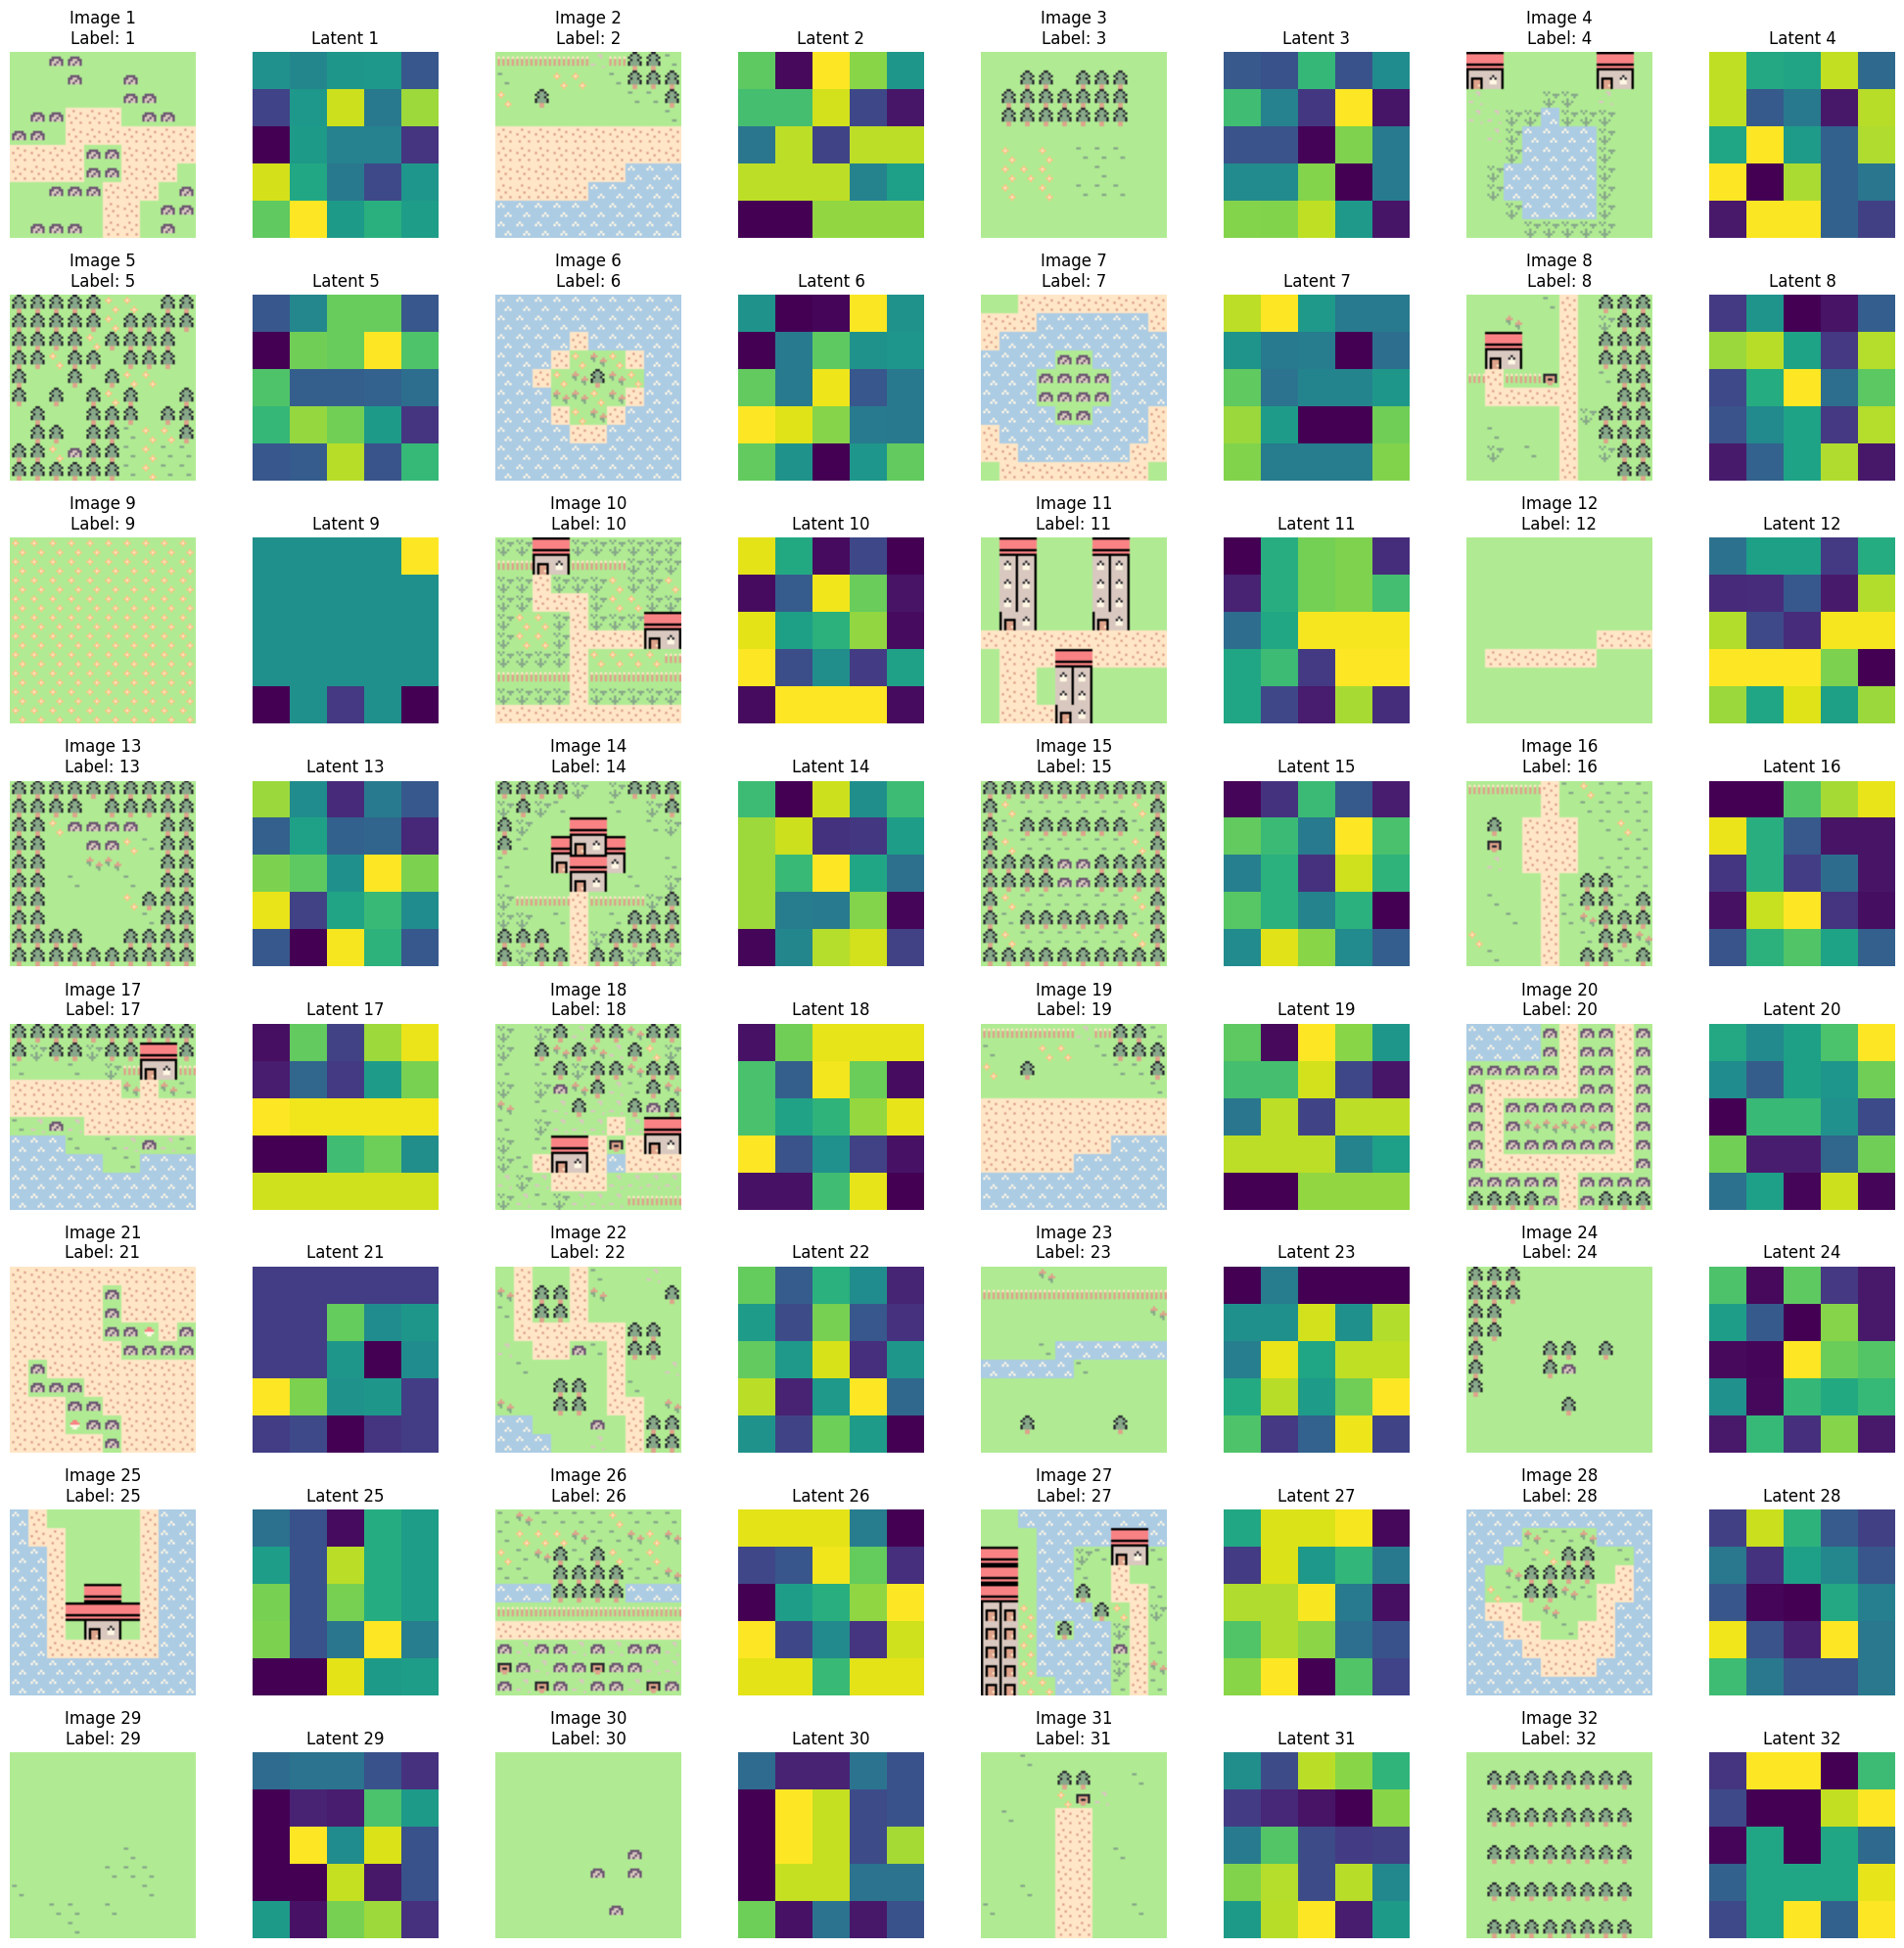

Shape of latent_indices: torch.Size([32, 5, 5])
Shape of original images: torch.Size([32, 16, 10, 10])


In [45]:
# Function to encode and quantize images
def encode_and_quantize(vqgan, images):
    vqgan.eval()
    with torch.no_grad():
        print(f'images size: {images.size()}')
        encoded = vqgan.ae.encoder(images)
        print(f'encoded size: {encoded.size()}')
        zq, _, quant_stats = vqgan.ae.quantize(encoded)
        print(f'zq shape: {zq.size()}')
        latent_indices = quant_stats["min_encoding_indices"]
        print(f'latent_indices size: {latent_indices.size()}')
        latent_indices = latent_indices.view((encoded.size()[0], encoded.size()[2], encoded.size()[3]))
        print(f'latent_indices viewed size: {latent_indices.size()}')

    return zq, latent_indices

# Get 32 images from the dataset
# images = []
# dataloader = iter(train_loader)
# while len(images) < 32:
#     batch, batch_labels = next(dataloader)
#     images.extend(batch)
#     if len(images) >= 32:
#         break

# Get 32 maps from the dataset
batch = next(iter(train_loader))
if isinstance(batch, (tuple, list)):
    images = batch[0][:32]  # Get first 32 maps from batch
else:
    images = batch[:32]
    
images = images.to(device)  # Remove the stack operation, just move to GPU

# images = torch.stack(images[:32]).to(device)  # Take exactly 32 images and move to GPU

# Encode and quantize the images
zqs, latent_indices = encode_and_quantize(loaded_vqgan, images)
print(f'zqs shape: {zqs.shape}')

latent_file = '../model_logs/' + H.log_dir + '/latent_indices.npy'
np.save(latent_file, latent_indices.cpu().numpy())

zq_file = '../model_logs/' + H.log_dir + '/quantized_latents.npy'
np.save(zq_file, zqs.cpu().numpy())

print(f"Saved latent indices to {latent_file}")



# Display the original images and their latent representations
fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(32):
    row = i // 4
    col = (i % 4) * 2
    
    # Display original image
    # img = images[i].cpu().permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    img = visualizer.map_to_image(images[i].cpu().permute(1, 2, 0).numpy())
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Image {i+1}\nLabel: {i+1}")
    
    # Display latent representation
    axes[row, col+1].imshow(latent_indices[i].cpu(), cmap='viridis')
    axes[row, col+1].axis('off')
    axes[row, col+1].set_title(f"Latent {i+1}")

plt.tight_layout()
plt.show()

# Print the shape of latent_indices for debugging
print(f"Shape of latent_indices: {latent_indices.shape}")
print(f"Shape of original images: {images.shape}")

In [ ]:
unique_code_ids

In [47]:
np.random.choice(unique_code_ids.tolist())

198

In [53]:
np.random.randint(H.codebook_size)


219

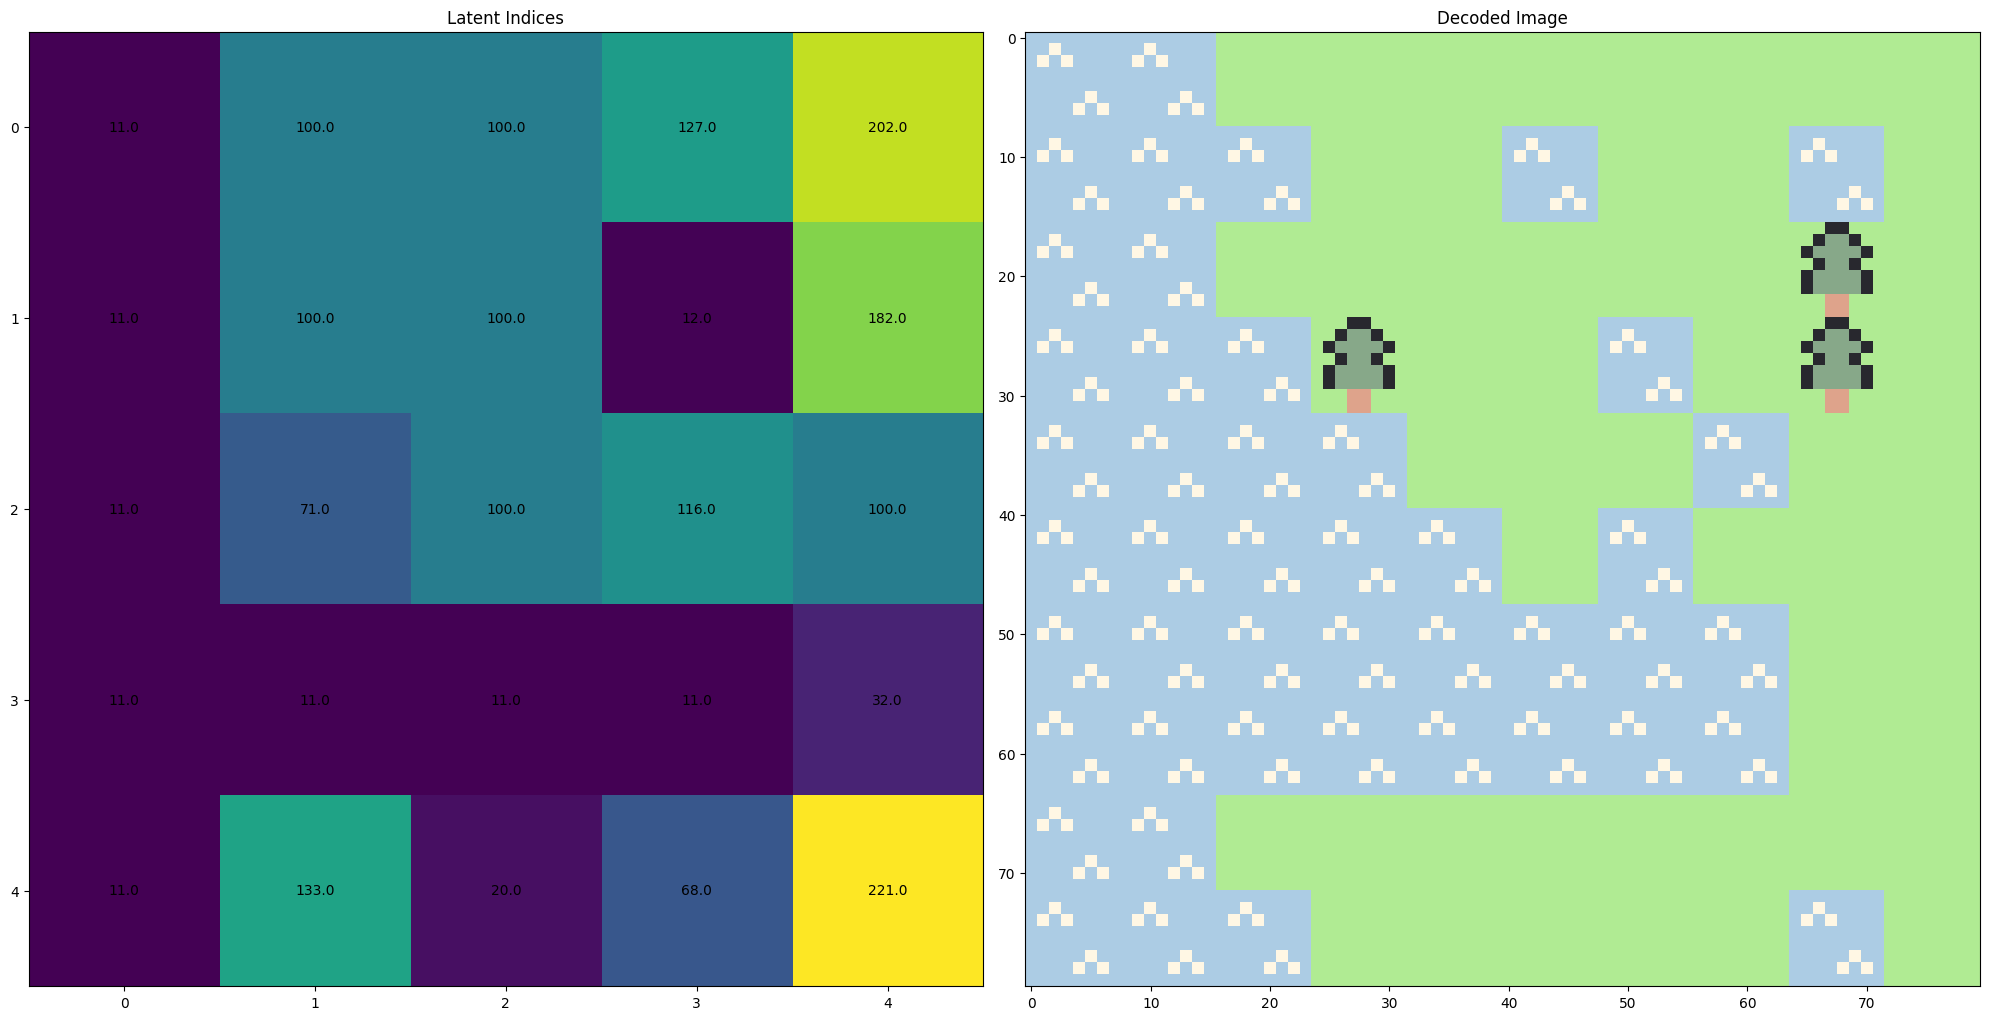

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Text, Button, VBox, HBox, GridspecLayout
from IPython.display import display, clear_output

# Function to decode latent indices and display the result
def decode_and_display(vqgan, latent_indices):
    # Ensure the model is in evaluation mode
    vqgan.eval()
    
    # Convert the input to a tensor and move to the same device as the model
    latent_indices = torch.tensor(latent_indices, device=device).unsqueeze(0)
    
    # Get the spatial dimensions of the latent space
    latent_h, latent_w = latent_indices.shape[1], latent_indices.shape[2]
    
    with torch.no_grad():
        # Get the codebook entries for the latent indices
        codebook_entries = vqgan.ae.quantize.get_codebook_entry(latent_indices.view(-1), shape=(1, latent_h, latent_w, vqgan.ae.embed_dim))
        
        # Use the decoder to generate the image
        decoded_image = vqgan.ae.generator(codebook_entries)
    
    # Move the image to CPU and convert to float32 for display
    decoded_image = decoded_image.detach().cpu().to(torch.float32)
    
    # Create an image of the latent indices grid
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Left subplot: Grid of latent indices
    ax1 = axes[0]
    ax1.imshow(latent_indices.squeeze().cpu().numpy(), cmap='viridis')
    for (i, j), z in np.ndenumerate(latent_indices.squeeze().cpu().numpy()):
        ax1.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

    ax1.set_title('Latent Indices')
    
    # Right subplot: Decoded image
    ax2 = axes[1]
    if decoded_image.dim() == 4:
            decoded_image = decoded_image.squeeze(0)
    if H.dataset == "maps":
        img = visualizer.map_to_image(decoded_image.cpu().permute(1, 2, 0).numpy())
    else:
        img = decoded_image.cpu().permute(1, 2, 0).numpy()
    # ax2.imshow(decoded_image.squeeze(), cmap='gray')
    ax2.imshow(img)
    ax2.set_title('Decoded Image')
    
    plt.tight_layout()
    plt.show()

# Function to create an interactive grid with text inputs
def create_interactive_grid(latent_h, latent_w, codebook_size):
    grid = GridspecLayout(latent_h, latent_w)
    text_inputs = []
    for i in range(latent_h):
        row = []
        for j in range(latent_w):
            # text_input = Text(value=str(np.random.choice(unique_code_ids.tolist())), layout={'width': '50px'})
            text_input = Text(value=str(np.random.randint(codebook_size)), layout={'width': '50px'})
            grid[i, j] = text_input
            row.append(text_input)
        text_inputs.append(row)
    return grid, text_inputs

# Function to get the values from the text inputs
def get_latent_indices_from_text_inputs(text_inputs):
    latent_indices = np.zeros((len(text_inputs), len(text_inputs[0])), dtype=np.int64)
    for i, row in enumerate(text_inputs):
        for j, text_input in enumerate(row):
            latent_indices[i, j] = int(text_input.value)
    return latent_indices

# Example usage:
latent_h, latent_w = 5, 5
codebook_size = H.codebook_size

# Create the interactive grid
grid, text_inputs = create_interactive_grid(latent_h, latent_w, codebook_size)

# Create a button to trigger the decoding
button = Button(description="Run")

# Function to handle button click
def on_button_click(b):
    clear_output(wait=True)
    latent_indices = get_latent_indices_from_text_inputs(text_inputs)
    decode_and_display(loaded_vqgan, latent_indices)
    display(VBox([grid, button]))  # Re-display the grid and button

button.on_click(on_button_click)

# Display the grid and button
display(VBox([grid, button]))

In [50]:
unique_code_ids

tensor([ 13,  42,  56,  83,  84, 141, 166, 173, 185, 203, 207, 219, 235, 268,
        275, 280, 282, 286, 287, 308, 309, 321, 325, 337, 346, 349, 378, 385,
        386, 397, 415, 425, 438, 441, 446, 452, 458, 459, 475, 507, 510])